<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch%20Applstra_%E4%BA%88%E6%B8%AC%E7%B5%90%E6%9E%9C%E3%82%921%E3%81%A4%E3%81%9A%E3%81%A4%E8%A1%A8%E7%A4%BA2.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#予測結果を1つずつ表示する

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
class pycolor:
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    PURPLE = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    RETURN = '\033[07m' #反転
    ACCENT = '\033[01m' #強調
    FLASH = '\033[05m' #点滅
    RED_FLASH = '\033[05;41m' #赤背景+点滅
    END = '\033[0m'

#Google colabをマウント

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#モデルのロード

In [33]:
# モデルの設定
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device) #model_ftをGPUに載せる

# 重みロード
PATH = '/content/drive/My Drive/Deep_learning/applstra/applstra.pth'
model_ft.load_state_dict(torch.load(PATH))

#評価モードにする
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
#モデルのサマリー（省略可）
from torchsummary import summary
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#画像とラベル表示のための関数を定義

In [36]:
#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      print('Image: '+ image_name)
      label = os.path.basename(os.path.dirname(image_path))
      print('Label: '+ label)
      return(image_name, label)

'''
#変形後の画像を表示
def image_transform(image_path):

    image=Image.open(image_path)

    
    #変形した画像を表示する
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
    image_transformed = transform(image)
    plt.imshow(np.array(image_transformed))
'''

#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)

#モデルにした処理した画像を投入して予測結果を表示
def evaluation(image_tensor, label):
    output = model_ft(Variable(image_tensor))
    #print(output.size())  # torch.Size([1, 1000])
    #print(output)

    #正解は青色、不正解は赤色で表示する
    _, pred = torch.max(output, 1)

    if label == class_name[pred]:
        answer = True
    if label != class_name[pred]:
        answer = False

    return(pred, answer)  #class_nameの番号で出力される

'''
def showResult(image_path, label, pred, answer)
    img = Image.open(image_path)
    plt.show(np.array(img))
'''

'\ndef showResult(image_path, label, pred, answer)\n    img = Image.open(image_path)\n    plt.show(np.array(img))\n'

#メインプログラム



In [37]:
#ファイル名の取得
image_path = glob.glob("/content/drive/My Drive/Deep_learning/applstra/val/*/*")
print(len(image_path))
print(image_path)

#ファイル名よりラベルを抜き出し、'class_name'と定義
class_name = []
class_path = glob.glob('/content/drive/My Drive/Deep_learning/applstra/val/*')
for i in class_path:
    class_name.append(os.path.basename(i))  
print(class_name)

127
['/content/drive/My Drive/Deep_learning/applstra/val/appl/mitukoto--770x507.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/pd_3e7850611c4cf3ea9261cde0e41656c63703be8f.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/mitu--770x513.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/mrk003_1.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/natsuakari.JPG', '/content/drive/My Drive/Deep_learning/applstra/val/appl/P2019047.JPG', '/content/drive/My Drive/Deep_learning/applstra/val/appl/pd_d81aa71d05b502c92a0b0bc2eb59b81060a74d20.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/PED_kajiraretaapple2_TP_V4.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/ph00161251.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/photo-1505872342847-6dbb5e76cd31-768x512_1400x.progressive.jpeg.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/ph_kikuchi_ringo02.jpg', '/content/drive/My Drive/Deep_le

In [0]:
for i in image_path:
    image_name, label = getlabel(i)  #画像の名前とラベルを取得
    image_tensor = image_transform(i)  #評価のための画像下処理
    #pred, answer = evaluation (image_tensor, label)　#画像をモデルに投入しラベルを予測


In [9]:
image_path = image_path[0:10]
len(image_path)

10

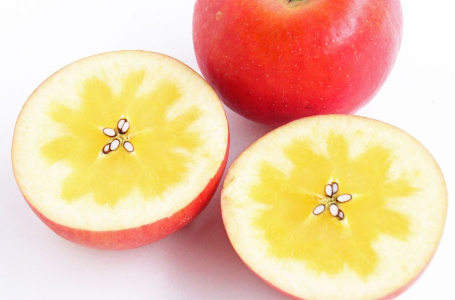

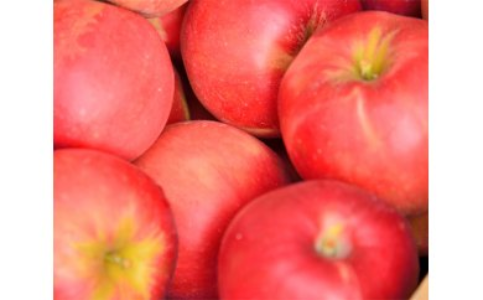

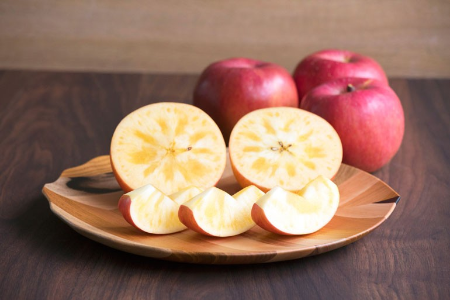

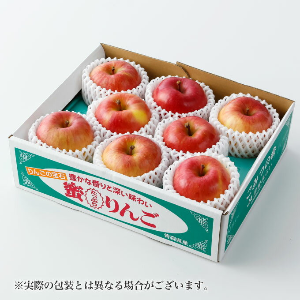

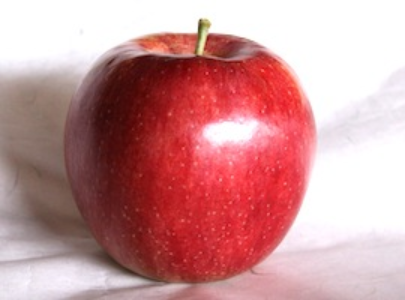

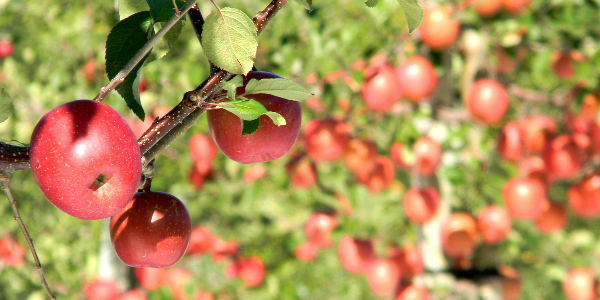

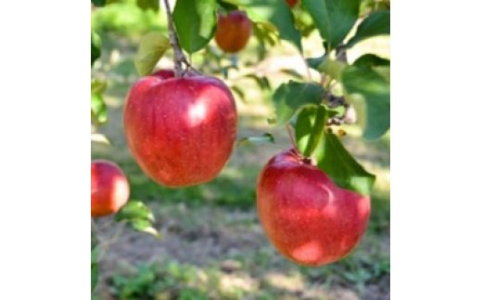

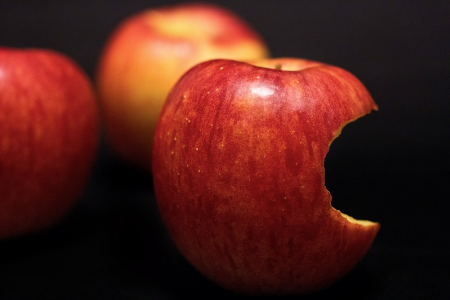

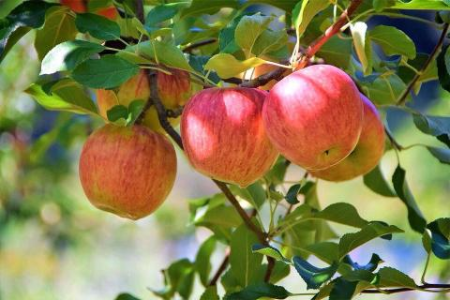

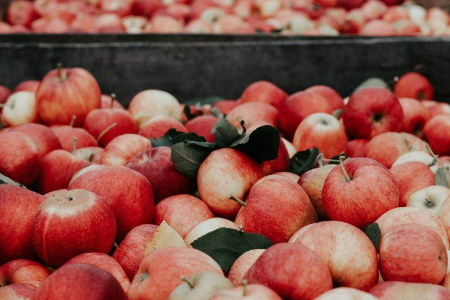

In [26]:
#OPEN CVを用いた全画像表示（時間かかる）

for i in image_path:

    #画像のインポート
    img = cv2.imread(i, cv2.IMREAD_UNCHANGED)
    
    #画像のリサイズ
    height = img.shape[0]
    width = img.shape[1]
    resized_img = cv2.resize(img, (int(width*300/height), 300))
    cv2_imshow(resized_img)



